### Step 0. 금융 데이터 소개 및 예측 모델 개요
고객 소득구간 예측문제는 금융 데이터 분석에서 가장 중요한 문제 중 하나라고 할 수 있습니다. 분석에 들어가기 앞서 2가지 사항을 짚어보도록 하겠습니다.

#### 금융 데이터의 속성
금융 데이터는 주로 아래의 특성을 띄게 됩니다.
- 1) 이종(heterogeneous) 데이터의 결합: 데이터의 원천·형태·스케일 등이 서로 다른 성격을 가짐
- 2) 분포의 편향성(skewedness): 예측값과 정답이 멀리 떨어져 있으면 학습 결과의 편향(bias)이 높을 수 있음
- 3) 분류 레이블의 불명확성: 소득구간·신용등급·상품종류 등은 비즈니스 로직을 포함하므로 분류가 임의적 → 분석가의 해석력이 중요
- 4) 변수의 다중공선성(multicollinearity): 변수간 상호의존이나 상관관계가 강하게 나타날 수 있음
- 5) 변수의 비선형성: 변수의 영향력이 선형적이지 않을 수 있음, e.g.) 나이가 소득에 미치는 영향은?
- 그 외 현실적인 규제·수집·저장 등의 한계 때문에 데이터가 불완전(missing, truncated, censored)할 수 있음

#### 다중분류와 소득구간 예측
예측할 클래스(레이블 혹은 레벨이라고도 합니다)가 3개 이상인 경우를 다중분류 문제라고 합니다. <br>단순하게는 Multiclass classification, 회귀방법론을 쓴다면 Multinomial logistic regression 이라는 명칭으로 불립니다.<br>클래스간 위계관계(포함관계)는 동등하다고 가정하겠습니다.

소득구간 예측은 전형적인 다중분류 문제입니다. 분석에 앞서 다음과 같은 사항을 생각해 봅시다.
- 1) 클래스간 구분이 명확하지 않을 경우: 소득구간 구분은 어떻게 지어야 하며, 클래스는 몇 개로 결정해야 할까요?
- 2) 클래스간 구분에 순서가 있을 경우: 정확하게 말하자면 각 소득구간은 순서가 있는(ordinal) 클래스로 보아야 할 것입니다.
- 3) 특정 클래스에 해당하는 값이 부족할 경우: 고소득 구간 고객 수와 중소득 구간 고객의 수가 현저히 차이가 날 때 어떻게 해결할까요?

다중분류 문제는 이진분류 대비 아래와 같은 추가 고려사항이 있습니다.
- 1) 모델 구현할 때 주의사항: 변수의 원-핫-인코딩 처리, 목적함수의 결정 등
- 2) 결과 해석할 때 주의사항: 정확도(Accuracy), F1 스코어, Confusion Matrix 등
- 실제 분석에서 자세히 다루도록 하겠습니다.

학습목표
- 1) 이진분류·다중분류 모델의 이해
- 2) 선형 기반·트리 기반 분류모델의 이해
- 3) 변수 처리 방법에 대한 이해
- 4) 분류모델 결과를 해석하는 방법 습득
- 5) 평가결과를 바탕으로 모델을 개선하는 방법 습득

### 1. 데이터 불러오기


In [2]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
df=pd.io.parsers.read_csv('https://media.githubusercontent.com/media/mchoimis/FinancialML/main/income/income.csv')
df

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [4]:
df.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
       'marital.status', 'occupation', 'relationship', 'race', 'sex',
       'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
       'income'],
      dtype='object')

##### 데이터셋에 대한 정보
- age : 나이
- workclass: 직업구분
- education: 교육수준
- education.num: 교육수준(numerically coded)
- marital.status: 혼인상태
- occupation : 직업
- relationship: 가족관계
- race: 인종
- sex: 성별
- capital.gain: 자본이득
- capital.loss: 자본손실
- hours.per.week: 주당 근로시간
- income : 소득 구분 

### 2. 데이터 미리보기

In [5]:
# 데이터 형태
df.shape, df.columns

((32561, 15),
 Index(['age', 'workclass', 'fnlwgt', 'education', 'education.num',
        'marital.status', 'occupation', 'relationship', 'race', 'sex',
        'capital.gain', 'capital.loss', 'hours.per.week', 'native.country',
        'income'],
       dtype='object'))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


### 3. 데이터 확인

In [7]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [8]:
# ? -> NaN로 변경
df[df=='?']=np.nan

In [9]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [10]:
df.isna().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [11]:
# 최빈값 계산
print(df['workclass'].mode())

0    Private
dtype: object


In [12]:
# 결측지를 최빈값으로 채우기
for col in ['workclass', 'occupation', 'native.country']:
    df[col].fillna(df[col].mode()[0], inplace=True)

df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [13]:
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,Private,77053,HS-grad,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,Private,186061,Some-college,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


#### 4. input/target 구성

In [14]:
X=df.drop(['fnlwgt','education','income'],axis=1)
y=df['income']

display(X.head())
display(y.head())

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,90,Private,9,Widowed,Prof-specialty,Not-in-family,White,Female,0,4356,40,United-States
1,82,Private,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States
2,66,Private,10,Widowed,Prof-specialty,Unmarried,Black,Female,0,4356,40,United-States
3,54,Private,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States
4,41,Private,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States


0    <=50K
1    <=50K
2    <=50K
3    <=50K
4    <=50K
Name: income, dtype: object

#### train/test 데이터셋으로 나누기

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(22792, 12) (9769, 12)
(22792,) (9769,)


In [16]:
X_train.head(3)

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
32098,40,State-gov,13,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,20,United-States
25206,39,Local-gov,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,38,United-States
23491,42,Private,10,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
X_train.head(3)

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
32098,40,State-gov,13,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,20,United-States
25206,39,Local-gov,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,38,United-States
23491,42,Private,10,Never-married,Exec-managerial,Not-in-family,White,Female,0,0,40,United-States


#### 6. 범주형 데이터 처리

In [18]:
X_train.dtypes

age                int64
workclass         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
dtype: object

In [19]:
# X_train에서 범주형 변수 변경
from sklearn.preprocessing import LabelEncoder

ctg=['workclass','marital.status','occupation','relationship','race','sex','native.country']

for feature in ctg:
    le=LabelEncoder()  # 모델 생성
    X_train[feature]=le.fit_transform(X_train[feature])  # 범부형 변수 변환
    X_test[feature]=le.transform(X_test[feature])


In [20]:
X_train[ctg].head(3) # 변경된 X 값들만 확인

,workclass,marital.status,occupation,relationship,race,sex,native.country
32098,6,2,3,5,4,0,38
25206,1,2,6,0,4,1,38
23491,3,4,3,1,4,0,38


In [21]:
X_test[ctg].head(3)

,workclass,marital.status,occupation,relationship,race,sex,native.country
22278,3,6,11,4,4,0,38
8950,3,4,5,3,4,0,38
7838,3,4,7,1,1,0,39


In [22]:
## [참조] 원-핫-인코딩
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
tmp=enc.fit_transform(X_train[ctg]).toarray()
pd.DataFrame(tmp).head()

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### 7. 피처 스케일 조정

In [23]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
X_train_scaled=pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled=pd.DataFrame(scaler.transform(X_test), columns=X.columns)

In [24]:
X_train_scaled.head()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
0,0.101484,2.600478,1.133894,-0.402341,-0.782234,2.214196,0.39298,-1.430470,-0.145189,-0.217407,-1.662414,0.262317
1,0.028248,-1.884720,-0.423425,-0.402341,-0.026696,-0.899410,0.39298,0.699071,-0.145189,-0.217407,-0.200753,0.262317
2,0.247956,-0.090641,-0.034095,0.926666,-0.782234,-0.276689,0.39298,-1.430470,-0.145189,-0.217407,-0.038346,0.262317
3,-0.850587,-1.884720,-0.423425,0.926666,-0.530388,0.968753,0.39298,0.699071,-0.145189,-0.217407,-0.038346,0.262317
4,-0.044989,-2.781760,1.523223,-0.402341,-0.782234,-0.899410,0.39298,0.699071,-0.145189,-0.217407,-0.038346,0.262317


In [25]:
X_train.describe()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
count,22792.000000,22792.000000,22792.000000,22792.000000,22792.000000,22792.000000,22792.000000,22792.000000,22792.000000,22792.000000,22792.000000,22792.000000
mean,38.614294,3.101044,10.087575,2.605476,6.106002,1.444323,3.666462,0.671727,1064.423043,87.756581,40.472227,36.411241
std,13.654750,1.114802,2.568573,1.504916,3.970769,1.605890,0.848759,0.469595,7331.442737,403.660431,12.315027,6.056766
min,17.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,3.000000,9.000000,2.000000,3.000000,0.000000,4.000000,0.000000,0.000000,0.000000,40.000000,38.000000
50%,37.000000,3.000000,10.000000,2.000000,6.000000,1.000000,4.000000,1.000000,0.000000,0.000000,40.000000,38.000000
75%,48.000000,3.000000,12.000000,4.000000,9.000000,3.000000,4.000000,1.000000,0.000000,0.000000,45.000000,38.000000
max,90.000000,7.000000,16.000000,6.000000,13.000000,5.000000,4.000000,1.000000,99999.000000,4356.000000,99.000000,40.000000


In [26]:
X_train_scaled.describe()

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country
count,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04,2.279200e+04
mean,1.756717e-16,1.025661e-16,-2.157316e-16,1.932856e-17,5.549167e-17,-3.179860e-17,-4.738614e-17,-2.244607e-17,5.611517e-18,5.237416e-17,-1.839331e-17,-4.507919e-16
std,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00,1.000022e+00
min,-1.582949e+00,-2.781760e+00,-3.538063e+00,-1.731347e+00,-1.537772e+00,-8.994102e-01,-4.319887e+00,-1.430470e+00,-1.451892e-01,-2.174068e-01,-3.205279e+00,-6.011796e+00
25%,-7.773505e-01,-9.064068e-02,-4.234251e-01,-4.023406e-01,-7.822339e-01,-8.994102e-01,3.929802e-01,-1.430470e+00,-1.451892e-01,-2.174068e-01,-3.834644e-02,2.623172e-01
50%,-1.182248e-01,-9.064068e-02,-3.409539e-02,-4.023406e-01,-2.669619e-02,-2.766891e-01,3.929802e-01,6.990710e-01,-1.451892e-01,-2.174068e-01,-3.834644e-02,2.623172e-01
75%,6.873733e-01,-9.064068e-02,7.445640e-01,9.266662e-01,7.288415e-01,9.687533e-01,3.929802e-01,6.990710e-01,-1.451892e-01,-2.174068e-01,3.676705e-01,2.623172e-01
max,3.763293e+00,3.497518e+00,2.301883e+00,2.255673e+00,1.736225e+00,2.214196e+00,3.929802e-01,6.990710e-01,1.349485e+01,1.057408e+01,4.752654e+00,5.925337e-01


#### 8. 선형분류모델 구현

- Logistic Regression 모델

In [27]:
# Feature scaling 전 원본 데이터
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

lr=LogisticRegression()
lr.fit(X_train,y_train)

pred=lr.predict(X_test)

accscr=accuracy_score(y_test,pred)
print('LogisticRegresstion accuracy_score: %.4f'%(accscr))

LogisticRegresstion accuracy_score: 0.8057


In [28]:
# Feature scaling을 진행한 데이터
lr=LogisticRegression()
lr.fit(X_train_scaled, y_train)
pred=lr.predict(X_test_scaled)

lr_score=accuracy_score(y_test, pred)
print('LogisticRegression accuracy_score: %.4f'%(lr_score))

LogisticRegression accuracy_score: 0.8222


In [29]:
# 스케일 조정된 데이터를 이용한 로지스틱 회기 확인
from sklearn.metrics import classification_report

cr_logreg=classification_report(y_test,pred)
print(cr_logreg)

              precision    recall  f1-score   support

       <=50K       0.84      0.94      0.89      7410
        >50K       0.71      0.44      0.55      2359

    accuracy                           0.82      9769
   macro avg       0.78      0.69      0.72      9769
weighted avg       0.81      0.82      0.81      9769



- Random Forest 모델 구현(결정트리 기반)

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc=RandomForestClassifier()
rfc.fit(X_train, y_train)

pred=rfc.predict(X_test)
rfc_score=accuracy_score(y_test, pred)
print('RandomForestClassifier accuracy_score: %.4f'%(rfc_score))

RandomForestClassifier accuracy_score: 0.8481


In [31]:
# Confusion Matrix 확인
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test, pred)
print(cm)

[[6841  569]
 [ 915 1444]]


In [32]:
print('\nRecall for Class [<=50K] = ', cm[0,0], '/' , cm[0,0] + cm[0,1])
print('\nPrecision for Class [<=50K] = ', cm[0,0], '/' , cm[0,0] + cm[1,0])
print('\nRecall for Class [>50K] = ', cm[1,1], '/' , cm[1,0] + cm[1,1])
print('\nPrecision for Class [>50K] = ', cm[1,1], '/' , cm[0,1] + cm[1,1])


Recall for Class [<=50K] =  6841 / 7410

Precision for Class [<=50K] =  6841 / 7756

Recall for Class [>50K] =  1444 / 2359

Precision for Class [>50K] =  1444 / 2013


In [33]:
from sklearn.metrics import classification_report
cr_rfc=classification_report(y_test, pred)
print(cr_rfc)

              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      7410
        >50K       0.72      0.61      0.66      2359

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.84      9769



In [34]:
y_test.unique()

array(['<=50K', '>50K'], dtype=object)

- 부스팅 기반 분류 모델
    - 부스팅 계열 모델: AdaBoost, Gradient Boosting Model(GBM), XGBoost, LightGBM 

In [35]:
from sklearn.ensemble import GradientBoostingClassifier

gbc=GradientBoostingClassifier(random_state=0)
gbc.fit(X_train, y_train)

pred=gbc.predict(X_test)
gbc_score=accuracy_score(y_test, pred)
print('GradientBoosting accuracy_score: %.4f'%(gbc_score))

GradientBoosting accuracy_score: 0.8621


In [36]:
gbc=GradientBoostingClassifier(random_state=0)
gbc.fit(X_train_scaled, y_train)

pred_scaled=gbc.predict(X_test_scaled)
gbc_score_scaled=accuracy_score(y_test, pred_scaled)
print('Gradient Boosting accuracy score: %.4f'%(gbc_score_scaled))

Gradient Boosting accuracy score: 0.8621


In [37]:
# 모델의 분류결과 확인
from sklearn.metrics import classification_report

cm_gbc=classification_report(y_test,pred)
print(cm_gbc)

              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      7410
        >50K       0.78      0.59      0.68      2359

    accuracy                           0.86      9769
   macro avg       0.83      0.77      0.79      9769
weighted avg       0.86      0.86      0.86      9769



- Light GBM 분류 모델

In [38]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

lgbm=LGBMClassifier(random_state=0)
lgbm.fit(X_train, y_train)

pred=lgbm.predict(X_test)
lgbm_score=accuracy_score(y_test, pred)
print('LGBM Classifie accuracy score: %.4f'%(lgbm_score))

LGBM Classifie accuracy score: 0.8677


In [39]:
cm_lgbm=classification_report(y_test, pred)
print(cm_lgbm)

              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91      7410
        >50K       0.77      0.65      0.70      2359

    accuracy                           0.87      9769
   macro avg       0.83      0.79      0.81      9769
weighted avg       0.86      0.87      0.86      9769



In [40]:
print('accuracy score')
print('lr_score: %.5f'%(lr_score))
print('rfc_score: %.5f'%(rfc_score))
print('gbc_score: %.5f'%(gbc_score))
print('lgbm_score: %.5f'%(lgbm_score))

accuracy score
lr_score: 0.82219
rfc_score: 0.84809
gbc_score: 0.86211
lgbm_score: 0.86774


In [41]:
# 이진분류 모델 비교
print('rfc_score: %.5f'%(rfc_score))
print(cr_rfc)
print('gbc_score: %.5f'%(gbc_score))
print(cm_gbc)
print('lgbm_score: %.5f'%(lgbm_score))
print(cm_lgbm)

rfc_score: 0.84809
              precision    recall  f1-score   support

       <=50K       0.88      0.92      0.90      7410
        >50K       0.72      0.61      0.66      2359

    accuracy                           0.85      9769
   macro avg       0.80      0.77      0.78      9769
weighted avg       0.84      0.85      0.84      9769

gbc_score: 0.86211
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      7410
        >50K       0.78      0.59      0.68      2359

    accuracy                           0.86      9769
   macro avg       0.83      0.77      0.79      9769
weighted avg       0.86      0.86      0.86      9769

lgbm_score: 0.86774
              precision    recall  f1-score   support

       <=50K       0.89      0.94      0.91      7410
        >50K       0.77      0.65      0.70      2359

    accuracy                           0.87      9769
   macro avg       0.83      0.79      0.81      9769
weighted avg    

## 다중분류 모델

1. Light GBM 
- Gradient Boosting 모델의 단점을 극복하기 위해 샘플링 등의 기법을 이용하여 스캔하는 데이터 양을 줄임으로써 분석 시간을 획기적으로 단축시킨 방법론
- 범주변수가 많은 정형 데이터와 다중분류에 유용한 알고리즘

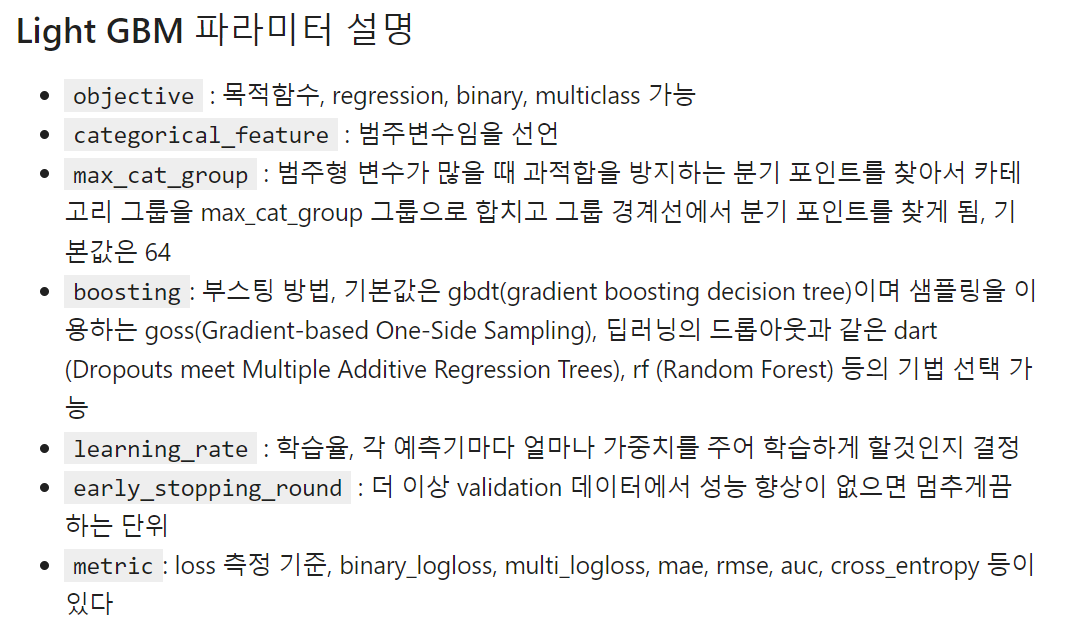

In [42]:
data=pd.io.parsers.read_csv('https://media.githubusercontent.com/media/mchoimis/FinancialML/main/income/income_ext.csv')
data.shape

(32561, 19)

In [43]:
32561*19

618659

In [44]:
# 데이터셋 구성
X = data.drop(['education', 'income', 'income.num'], axis=1)   # Drop columns
y = data['income.num']  # Choose column

In [45]:
# 다중분류 클래스 생성 함수
def value_change(x):
    if x <= 10000: return 0
    if x >  10000 and x <= 20000 : return 1
    if x >  20000 and x <= 30000 : return 2
    if x >  30000 and x <= 40000 : return 3
    if x >  40000 and x <= 50000 : return 4
    if x >  50000 and x <= 60000 : return 5
    if x >  60000 and x <= 70000 : return 6
    if x >  70000 and x <= 80000 : return 7
    if x >  80000 and x <= 90000 : return 8
    if x >  90000 and x <= 100000 : return 9
    return 10

In [46]:
y_=y.apply(lambda x: value_change(x))
y[:10], y_[:10]

(0    43713
 1    33113
 2    31652
 3    55087
 4    85583
 5    51526
 6    76643
 7    95860
 8    34909
 9    20036
 Name: income.num, dtype: int64, 0    4
 1    3
 2    3
 3    5
 4    8
 5    5
 6    7
 7    9
 8    3
 9    2
 Name: income.num, dtype: int64)

In [47]:
y_.unique()

array([ 4,  3,  5,  8,  7,  9,  2,  6,  1,  0, 10])

In [48]:
y_.value_counts()

6     3318
9     3310
7     3276
4     3273
8     3257
1     3250
5     3246
3     3233
2     3180
0     3176
10      42
Name: income.num, dtype: int64

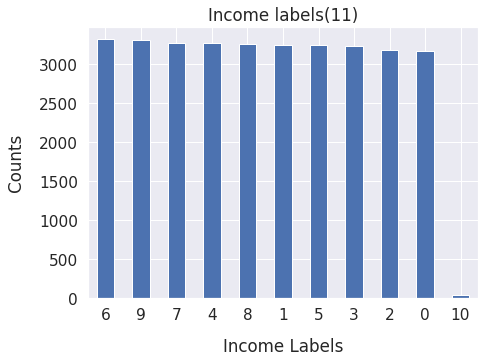

In [49]:
sns.set(font_scale=1.4)
y_.value_counts().plot(kind='bar', figsize=(7,5), rot=0)
plt.xlabel('Income Labels', labelpad=14)
plt.ylabel('Counts', labelpad=14)
plt.title('Income labels(11)')
plt.show()

- 학습 및 테스트 데이터셋 구성


In [50]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y_, test_size=0.3, random_state=0)

print(x_train.shape, x_test.shape)

(22792, 16) (9769, 16)


In [51]:
x_train.dtypes

age                int64
workclass         object
education.num      int64
marital.status    object
occupation        object
relationship      object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
spend.groc         int64
spend.med          int64
spend.trav         int64
asset              int64
balance            int64
native.country    object
dtype: object

In [52]:
from sklearn import preprocessing

categorical = ['workclass', 'marital.status', 'occupation', 'relationship', 'sex', 'native.country']

for feature in categorical:
    le=preprocessing.LabelEncoder()
    x_train[feature]=le.fit_transform(x_train[feature])
    x_test[feature]=le.transform(x_test[feature])


In [53]:
x_train[categorical].head(3)

,workclass,marital.status,occupation,relationship,sex,native.country
32098,7,2,4,5,0,39
25206,2,2,7,0,1,39
23491,4,4,4,1,0,39


- Light GBM 모델을 이용한 다중분류 구현

In [54]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

lgbm =  LGBMClassifier()
lgbm.fit(x_train, y_train)

LGBMClassifier()

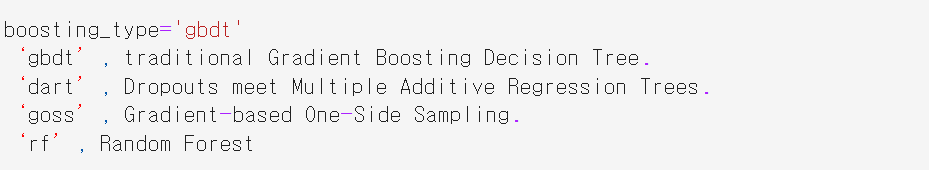

In [55]:
pred1=lgbm.predict(x_test)

lgbm_score=accuracy_score(y_test, pred1)
print('LGBM 모델 정화도: %.5f'%(lgbm_score))

LGBM 모델 정화도: 0.81185


In [56]:
lgbm.predict([x_test.iloc[0]])

array([6])

In [57]:
# 오차 행렬 출력
from sklearn.metrics import confusion_matrix

cm1 =  confusion_matrix(y_test, pred1)
print('LGBM Confusion Matrix for 11-class Labels\n')
print(cm1)

LGBM Confusion Matrix for 11-class Labels

[[934  41   4   3   1   0   2   3   0   0   0]
 [ 40 869  46  13   1   0   0   0   0   0   0]
 [ 23  42 807  45   7   0   2   2   0   2   0]
 [ 13  20  75 838  62   6   2   2   1   0   0]
 [ 11  17  16  73 758  70  12   4   5   3   0]
 [  8  13  18  22  76 758  78  12  11   6   0]
 [ 10   7  11  12  11  92 702  78  13  15   0]
 [ 12   8  10   8  11  12  77 730  91  23   0]
 [  7  10  10   6   9   7  12 102 727  88   0]
 [  8   7  10  16  16   6   7  29  62 808   0]
 [  0   0   0   0   0   0   0   0   0  12   0]]


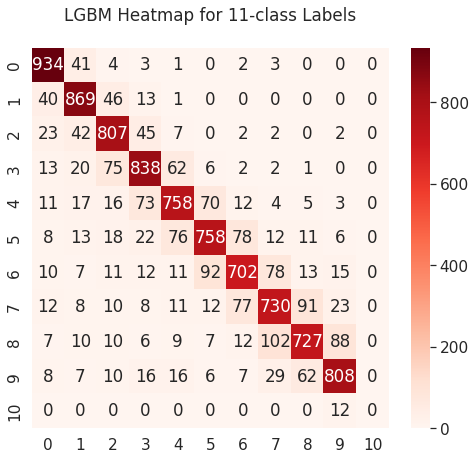

In [58]:
## 히트맵으로 시각화하기
plt.figure(figsize=[8,7])
sns.heatmap(cm1, cmap='Reds', annot=True, fmt='.0f')
plt.title('LGBM Heatmap for 11-class Labels\n')
plt.show()

In [59]:
print('LGBM Model accuracy score : %.4f'%(lgbm_score))
print('\n')
print(classification_report(y_test, pred1))

LGBM Model accuracy score : 0.8119


              precision    recall  f1-score   support

           0       0.88      0.95      0.91       988
           1       0.84      0.90      0.87       969
           2       0.80      0.87      0.83       930
           3       0.81      0.82      0.82      1019
           4       0.80      0.78      0.79       969
           5       0.80      0.76      0.78      1002
           6       0.79      0.74      0.76       951
           7       0.76      0.74      0.75       982
           8       0.80      0.74      0.77       978
           9       0.84      0.83      0.84       969
          10       0.00      0.00      0.00        12

    accuracy                           0.81      9769
   macro avg       0.74      0.74      0.74      9769
weighted avg       0.81      0.81      0.81      9769



- Random Forest 모델(다중분류 구현)

In [60]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc =  RandomForestClassifier() 
rfc.fit(x_train, y_train) 

RandomForestClassifier()

In [61]:
pred =  rfc.predict(x_test)
rfc_score =  accuracy_score(y_test, pred)
print('Random Forest Model accuracy score : %.4f'%(rfc_score))

Random Forest Model accuracy score : 0.7611


In [62]:
from sklearn.metrics import confusion_matrix
cm2 =  confusion_matrix(y_test, pred)
print('Random Forest Confusion Matrix for 11-class Labels\n')
print(cm2)

Random Forest Confusion Matrix for 11-class Labels

[[926  55   4   2   1   0   0   0   0   0   0]
 [ 56 827  66  11   4   2   2   0   1   0   0]
 [ 27  80 759  46   9   4   2   0   2   1   0]
 [ 18  16 105 769  84  12   5   3   4   3   0]
 [ 17  16  16  93 709  89  13   6   5   5   0]
 [ 13   9  26  21  93 703 104  17  10   6   0]
 [ 13  10   8  15  12  99 688  88   8  10   0]
 [ 12   8   9   9   8  23 117 673 103  20   0]
 [  7   9  13   5  11  12  19 123 639 140   0]
 [ 11   6  13  14  18  13  16  32 104 742   0]
 [  0   0   0   0   0   0   0   1   0  11   0]]


In [63]:
print(cm1)
print()
print(cm2)

[[934  41   4   3   1   0   2   3   0   0   0]
 [ 40 869  46  13   1   0   0   0   0   0   0]
 [ 23  42 807  45   7   0   2   2   0   2   0]
 [ 13  20  75 838  62   6   2   2   1   0   0]
 [ 11  17  16  73 758  70  12   4   5   3   0]
 [  8  13  18  22  76 758  78  12  11   6   0]
 [ 10   7  11  12  11  92 702  78  13  15   0]
 [ 12   8  10   8  11  12  77 730  91  23   0]
 [  7  10  10   6   9   7  12 102 727  88   0]
 [  8   7  10  16  16   6   7  29  62 808   0]
 [  0   0   0   0   0   0   0   0   0  12   0]]

[[926  55   4   2   1   0   0   0   0   0   0]
 [ 56 827  66  11   4   2   2   0   1   0   0]
 [ 27  80 759  46   9   4   2   0   2   1   0]
 [ 18  16 105 769  84  12   5   3   4   3   0]
 [ 17  16  16  93 709  89  13   6   5   5   0]
 [ 13   9  26  21  93 703 104  17  10   6   0]
 [ 13  10   8  15  12  99 688  88   8  10   0]
 [ 12   8   9   9   8  23 117 673 103  20   0]
 [  7   9  13   5  11  12  19 123 639 140   0]
 [ 11   6  13  14  18  13  16  32 104 742   0]
 [  0   0  

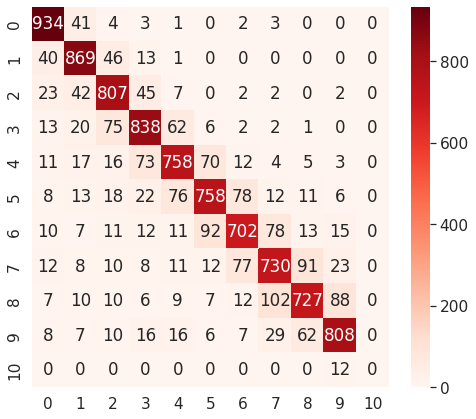

In [64]:
plt.figure(figsize=[8, 7])
sns.heatmap(cm1, cmap='Reds', annot=True, fmt='.0f')
plt.show()

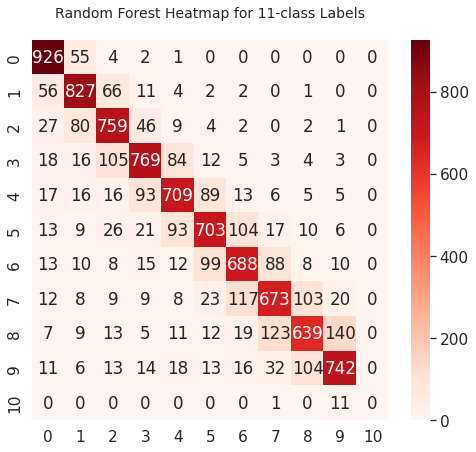

In [65]:
plt.figure(figsize=[8, 7])
sns.heatmap(cm2, cmap='Reds', annot=True, fmt='.0f')
plt.title('Random Forest Heatmap for 11-class Labels\n', fontsize=14)
plt.show()

- 적절한 클래스 수로 변환하여 모델 개선

In [66]:
def value_change(x):
    if x <= 20000: return 0
    if x >  20000 and x <= 50000 : return 1
    if x >  50000 and x <= 70000 : return 2
    if x >  70000 and x <= 90000 : return 3 
    return 4

y_ = data['income.num'].apply(lambda x: value_change(x))

In [67]:
y_.value_counts()

1    9686
2    6564
3    6533
0    6426
4    3352
Name: income.num, dtype: int64

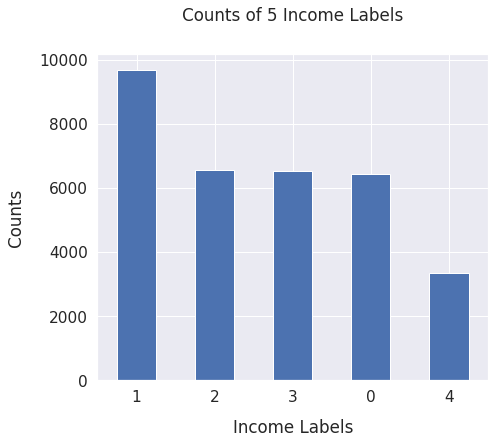

In [68]:
sns.set(font_scale=1.4)
y_.value_counts().plot(kind='bar', figsize=(7, 6), rot=0)
plt.xlabel("Income Labels", labelpad=14)
plt.ylabel("Counts", labelpad=14)
plt.title("Counts of 5 Income Labels\n", y=1.02);

In [69]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0) 

In [70]:
from sklearn import preprocessing

categorical = ['workclass', 'marital.status', 'occupation', 'relationship', 'sex', 'native.country']
for feature in categorical:
        le = preprocessing.LabelEncoder()
        x_train[feature] = le.fit_transform(x_train[feature])
        x_test[feature] = le.transform(x_test[feature])

In [ ]:
plt.figure(figsize=[8, 7])
sns.heatmap(cm2, cmap='Reds', annot=True, fmt='.0f')
plt.title('Random Forest Heatmap for 11-class Labels\n', fontsize=14)
plt.show()

In [72]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.00      1.00      0.00         1
           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5       0.00      0.00      0.00         0
           6       0.00      0.00      0.00         0
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0
          21       0.00      0.00      0.00         1
          41       0.00      0.00      0.00         1
          44       0.00      0.00      0.00         1
          93       0.00      0.00      0.00         1
         114       0.00      0.00      0.00         1
         119       0.00      0.00      0.00         1
         137       0.00      0.00      0.00         1
         144       0.00    

- Ligth GBM 다중분류 모델